<h1><font size="6">Bee or Wasp?</font></h1>

## Import libraries

In [3]:
import os
import gc
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *

print('TensorFlow version: %s' % tf.__version__)

2023-01-23 20:35:22.836798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 20:35:22.966558: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wanille/pg/heisenboerg/.fintech/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 20:35:22.966574: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-23 20:35:23.735934: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnv

TensorFlow version: 2.11.0


## set configurations and read metadata

In [4]:
ROOT = './kaggle_bee_vs_wasp/'
SEED = 42
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 256


df = pd.read_csv(ROOT+'labels.csv')
df.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [5]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

## Preprocess and plot

Check the dataset and preprocess it.

In [6]:
for idx in df.index:    
    df.loc[idx,'path']=df.loc[idx,'path'].replace('\\', '/') 
    
df.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


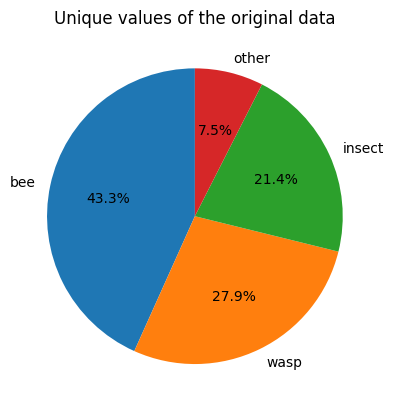

In [7]:
labels = list(df['label'].unique())
y = list(df['label'].value_counts())
plt.pie(y, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Unique values of the original data')
plt.show()

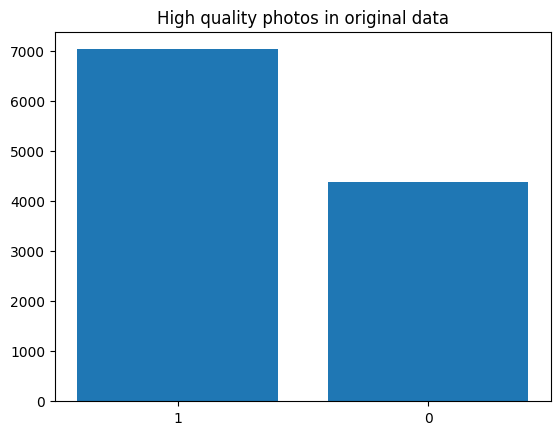

In [8]:
labels = list(df['photo_quality'].unique())
x = range(0, 2)
y = list(df['photo_quality'].value_counts())
plt.bar(x, y, tick_label=labels)
plt.title('High quality photos in original data')

plt.show()

In [9]:
# select only high quality photos
df = df.query('photo_quality == 1')
df['label'].value_counts()

bee       2469
insect    2439
wasp      2127
Name: label, dtype: int64

In [10]:
train_df = df.query('is_validation == 0 & is_final_validation == 0').reset_index(drop=True)
val_df = df.query('is_validation == 1').reset_index(drop=True)
test_df = df.query('is_final_validation == 1').reset_index(drop=True)

## Create datasets

In [12]:
def create_datasets(df, img_size):
    imgs = []
    for path in df['path'].to_list():
        img = cv2.imread(ROOT+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    imgs = imgs / 255.0
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_SIZE)
val_imgs, val_df = create_datasets(val_df, IMG_SIZE)
test_imgs, test_df = create_datasets(test_df, IMG_SIZE)

## Build the model

In [13]:
def build_model(img_size, n):
    inp = Input(shape=(img_size,img_size,n))
    resnet = tf.keras.applications.ResNet50(input_shape=(img_size,img_size,n), 
                                            weights='imagenet', 
                                            include_top=False)
    x = resnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x) 
    opt = tf.keras.optimizers.SGD(momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(IMG_SIZE, 3)
model.summary()

2023-01-23 20:36:11.647814: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wanille/pg/heisenboerg/.fintech/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 20:36:11.647834: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-23 20:36:11.647850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wanille-laptop): /proc/driver/nvidia/version does not exist
2023-01-23 20:36:11.648069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with

94765736/94765736 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 23,540,739
Non-trai

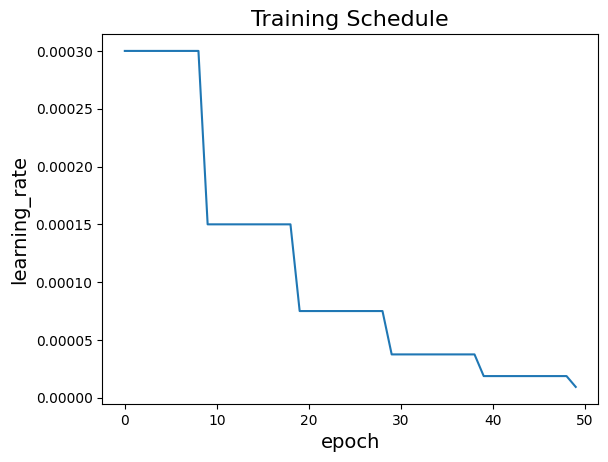

In [14]:
def get_lr_callback(batch_size=32, plot=False):
    start_lr = 3e-4
    def step_decay(epoch):
        drop = 0.5
        epochs_drop = 10.0
        lr = start_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)
    if plot == True:
        rng = [i for i in range(EPOCHS)]
        y = [step_decay(x) for x in rng]
        plt.plot(rng, y)
        plt.xlabel('epoch', size=14)
        plt.ylabel('learning_rate', size=14)
        plt.title('Training Schedule', size=16)
        plt.show()
        
    return lr_callback


get_lr_callback(plot=True)

1/1 [==============================] - 83s 83s/step - loss: 0.7355 - accuracy: 0.6000 - val_loss: 1.3550 - val_accuracy: 0.3001 - lr: 3.0000e-04


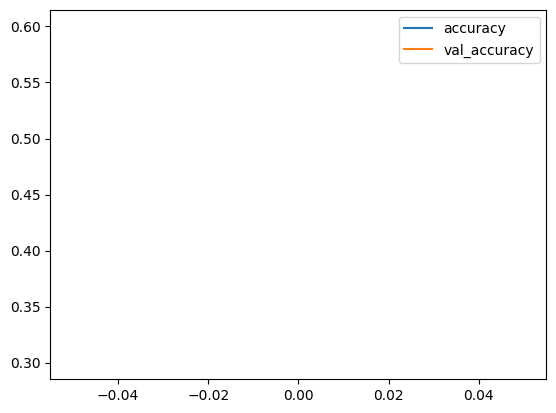

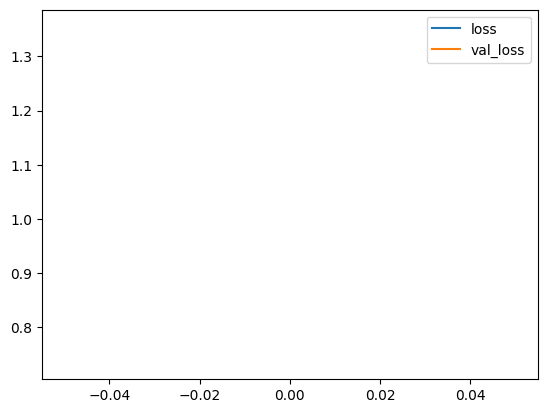

11376

In [19]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                               verbose=1, 
                                               restore_best_weights=True)

history = model.fit(train_imgs[:10], 
                    train_df[:10], 
                    batch_size=BATCH_SIZE, 
                    epochs=1, 
                    callbacks=[es_callback, get_lr_callback(BATCH_SIZE)], 
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

gc.collect()

In [20]:
model.evaluate(test_imgs, test_df) 

2023-01-23 20:40:27.975135: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 852492288 exceeds 10% of free system memory.


34/34 [==============================] - 84s 2s/step - loss: 1.3507 - accuracy: 0.3026


[1.3506560325622559, 0.3025830388069153]